# UNET

## Importing necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D, concatenate, Lambda
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## Getting Training and Testing Image

In [2]:
import os

train_images = []
for dirname, _, filenames in os.walk('/kaggle/input/dataset/dataset1/images_prepped_train'):
    for filename in filenames:
        train_images.append(os.path.join(dirname, filename))

test_images = []
for dirname, _, filenames in os.walk('/kaggle/input/dataset/dataset1/images_prepped_test'):
    for filename in filenames:
        test_images.append(os.path.join(dirname, filename))

## Defining our UNET Model along with VGG Encoder

In [3]:
batch_size = 2
nepochs = 5
nclasses = 12


def unet_with_vgg_encoder():
    
    # taking vgg16 pretrained model without top
    pretrained_model = VGG16(include_top=False, weights='imagenet', 
                            input_shape=(360, 480, 3))
    pretrained_model.summary()
    
    # taking input layer for the pretrained model
    input_layer = pretrained_model.input
    
    # fetching output of the 6th layer from the last
    output_layer_pretrained = pretrained_model.layers[-6].output
    encoder = Model(input_layer, output_layer_pretrained)
    
    # encoder is model with given input layer and output layer
    # we are setting trainable=false for all layers of encoder model
    for i in encoder.layers:
        i.trainable=False
        
    encoder.summary()
    
    # convolutional block 1
    lastPooling = MaxPooling2D(pool_size=(2, 2), padding='same')(output_layer_pretrained)
    center = Conv2D(1024, (3, 3), activation='relu', padding='same')(lastPooling)
    center = Conv2D(1024, (3, 3), activation='relu', padding='same')(center)
    center = BatchNormalization()(center)
    
    # convolutional block 2
    up4 = UpSampling2D((2, 2))(center)
    up4 = Conv2D(512, (2, 2), activation='relu', padding='same')(up4)
    up4 = Lambda(lambda x: x[:, 0:45, :, :])(up4)
    up4 = concatenate([up4, encoder.get_layer(name='block4_conv3').output], axis=3)
    up4 = Conv2D(512, (3, 3), activation='relu', padding='same')(up4)
    up4 = Conv2D(512, (3, 3), activation='relu', padding='same')(up4)
    up4 = Conv2D(512, (3, 3), activation='relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    
    # convolutional block 3
    up3 = UpSampling2D((2, 2))(up4)
    up3 = Conv2D(256, (2, 2), activation='relu', padding='same')(up3)
    up3 = concatenate([up3, encoder.get_layer(name='block3_conv3').output], axis=3)
    up3 = Conv2D(256, (3, 3), activation='relu', padding='same')(up3)
    up3 = Conv2D(256, (3, 3), activation='relu', padding='same')(up3)
    up3 = Conv2D(256, (3, 3), activation='relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    
    # convolutional block 4
    up2 = UpSampling2D((2, 2))(up3)
    up2 = Conv2D(128, (2, 2), activation='relu', padding='same')(up2)
    up2 = concatenate([up2, encoder.get_layer(name='block2_conv2').output], axis=3)
    up2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
    up2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
    up2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    
    # convolutional block 5
    up1 = UpSampling2D((2, 2))(up2)
    up1 = Conv2D(64, (2, 2), activation='relu', padding='same')(up1)
    up1 = concatenate([up1, encoder.get_layer(name='block1_conv2').output], axis=3)
    up1 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up1 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up1 = Conv2D(nclasses, (1, 1), activation='softmax', padding='same')(up1)
    
    model = Model(inputs=input_layer, outputs=up1)
    model.summary()
    return model


## Defining the training and the testing generators

**Training Generator**

In [4]:
# defining traingenerator function to fetch training images and their masks from the dataset
# using flow from dataframe

df = pd.DataFrame(train_images, columns=['image names'])


def traingenerator():
    image_datagen = ImageDataGenerator(rescale=1/255)
    mask_datagen = ImageDataGenerator()
    image_batch_generator = image_datagen.flow_from_dataframe(df,
                                                              directory='../input/dataset/dataset1/images_prepped_train',
                                                              x_col='image names',
                                                              class_mode=None,
                                                              target_size=(360, 480),
                                                              shuffle=False,
                                                              seed=2019,
                                                              batch_size=batch_size,
                                                              color_mode='rgb')
    
    mask_batch_generator = mask_datagen.flow_from_dataframe(df,
                                                            directory='../input/dataset/dataset1/annotations_prepped_train', 
                                                            x_col='image names',
                                                            class_mode=None,
                                                            target_size=(360, 480),
                                                            shuffle=False,
                                                            seed=2019,
                                                            batch_size=batch_size,
                                                            color_mode='grayscale')
    
    combined_generator = zip(image_batch_generator, mask_batch_generator)
    
    for (i, j) in combined_generator:
        new_mask = np.zeros(shape=(j.shape[0], j.shape[1], j.shape[2], nclasses))
        for k in range(j.shape[0]):
            mask = j[k]
            for m in range(nclasses):
                new_mask[k, :, :, m] = mask[:, :, 0] == m
        yield(i, new_mask)
    

**Testing Generator**

In [5]:
# defining testgenerator function to fetch testing images and their masks from the dataset
# using flow from dataframe

df1 = pd.DataFrame(test_images, columns=['image names'])


def testgenerator():
    image_datagen_test = ImageDataGenerator(rescale=1/255)
    image_batch_generator_test = image_datagen_test.flow_from_dataframe(df1,
                                                                        directory='../input/dataset/dataset1/images_prepped_test',
                                                                        x_col='image names',
                                                                        class_mode=None,
                                                                        target_size=(360, 480),
                                                                        shuffle=False,
                                                                        seed=2019,
                                                                        batch_size=batch_size,
                                                                        color_mode='rgb')
    for i in image_batch_generator_test:
        yield i

## Combining everything to finally make our UNET Model

In [6]:
unet = unet_with_vgg_encoder()
unet.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
             loss='categorical_crossentropy',
            metrics=['accuracy'])
unet.fit(traingenerator(), steps_per_epoch=400, epochs=nepochs)

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 480, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 360, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 360, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 180, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 180, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 180, 240, 128)     147584    
______________________________________________________________

In [7]:
results = unet.predict(testgenerator(), steps=51)

Found 101 validated image filenames.


results.shape :  (101, 360, 480, 12)
Unique in 0th prediction :  [0.00000000e+00 2.71348444e-38 4.47377931e-38 3.30570052e-37
 2.44260071e-36 1.80485147e-35 1.33361487e-34 5.97684694e-34
 9.85415445e-34 2.67863681e-33 7.28129045e-33 1.97925992e-32
 3.26324784e-32 5.38018651e-32 8.87042672e-32 3.97544995e-31
 1.08063920e-30 2.93748195e-30 7.98490480e-30 2.17052199e-29
 1.60381082e-28 4.35961013e-28 8.75651089e-27 2.38026637e-26
 6.47023468e-26 4.78089300e-25 1.29958149e-24 3.53262839e-24
 2.61027905e-23 1.92874977e-22 1.42516414e-21 2.34969821e-21
 3.87399781e-21 1.05306175e-20 2.86251861e-20 7.78113228e-20
 5.74952202e-19 4.24835413e-18 3.13913256e-17 8.53304829e-17
 2.31952270e-16 1.71390849e-15 4.65888577e-15 1.26641649e-14
 9.35762291e-14 2.54366569e-13 6.91440015e-13 5.10908893e-12
 1.38879429e-11 1.02618795e-10 2.78946810e-10 2.06115347e-09
 1.52299791e-08 1.12534465e-07 8.31528041e-07 1.37095719e-06
 6.14417377e-06 6.14417422e-06 1.01299902e-05 4.53978682e-05
 3.35350138e-04 2.47

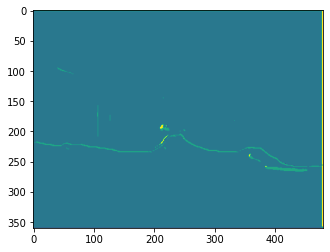

Unique in 0th prediction :  [ 0  1  3  4  6  9 10]


In [8]:
print("results.shape : ", results.shape)
print("Unique in 0th prediction : ", np.unique(results[0, :, :, :]))
img1 = np.argmax(results[0, :, :, :], axis=2)
print("0th prediction.shape : ", img1.shape)
img1 = np.reshape(img1, newshape=(360, 480))
print("0th prediction.shape : ", img1.shape)
plt.imshow(img1)
plt.show()
print("Unique in 0th prediction : ", np.unique(img1))